# Calculate Arrival Times

In [17]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np 
from xrsignal import xrsignal
from dask.distributed import Client
import hvplot.xarray
import pandas as pd
from scipy import signal
import dask
from NI_tools.NI_tools import inversion
import scipy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dask.config.set({'temporary_directory': '/datadrive/tmp'})
client = Client()
client

<Client: 'tcp://127.0.0.1:41389' processes=8 threads=32, memory=62.80 GiB>

### Calculate 201 hour average NCCF

In [5]:
fn = '/datadrive/NCCFs/1hr_20150101_20230101_ec_cc.nc'
NCCFs = xr.open_dataarray(fn)

#NCCFs = NCCFs.chunk({'delay':11999, 'time':1})

time_coord = pd.to_datetime(np.arange(pd.Timestamp('2015-01-01').value, pd.Timestamp('2023-01-01').value, 1e9*3600))

NCCFs = NCCFs.assign_coords({'time':time_coord})

NCCFs_201 = NCCFs.rolling(time=201, min_periods=1, center=True).mean()

In [20]:
nan_mask = np.isnan(NCCFs[:,0])
nan_mask_201 = nan_mask.rolling(time=201, min_periods=1, center=True).sum().drop_vars('delay')

In [32]:
ds_201 = xr.Dataset({'NCCFs':NCCFs_201, 'nan_count':nan_mask_201})

#### visualize 201 hr NCCF stack

In [17]:
fn = '/datadrive/NCCFs/axcc1_axec2_201.nc'
NCCFs_201 = xr.open_dataset(fn)

NCCFs_201 = NCCFs_201.chunk({'time':10, 'delay':11999})

In [19]:
NCCFs_201.hvplot.image(x='time', y='delay', rasterize=True, cmap='RdBu', ylim=(-6,6), width=1300, height=600, colorbar=False,)

:DynamicMap   []
   :Image   [time,delay]   (NCCFs)

In [29]:
NCCFs_201['NCCFs'][70000,:]

<xarray.DataArray 'NCCFs' (delay: 11999)>
dask.array<getitem, shape=(11999,), dtype=float64, chunksize=(11999,), chunktype=numpy.ndarray>
Coordinates:
  * delay    (delay) float64 -30.0 -29.99 -29.99 -29.98 ... 29.98 29.99 29.99
    time     datetime64[ns] 2022-12-26T16:00:00

In [32]:
inversion.hilbert_mag(NCCFs_201['NCCFs'].loc[pd.Timestamp('2018-10-1'),:], dim='delay').hvplot.line(label='before') * inversion.hilbert_mag(NCCFs_201['NCCFs'].loc[pd.Timestamp('2018-12-01'),:], dim='delay').hvplot.line()

:Overlay
   .Curve.Before :Curve   [delay]   (NCCFs)
   .Curve.I      :Curve   [delay]   (NCCFs)

#### save to disk

In [33]:
fn = '/datadrive/NCCFs/axcc1_axec2_201.nc'
ds_201.to_netcdf(fn)

## Calculate arrival time (non-whitened)

- filter NCCF to coherence cutoff
- calculate arrival time

### Filter NCCFs

In [3]:
ds_201 = xr.open_dataset('/datadrive/NCCFs/axcc1_axec2_201.nc')
ds_201 = ds_201.chunk({'time':15, 'delay':11999})

In [4]:
fcs = [46, 35, 31, 18]

for fc in fcs:
    b,a = signal.butter(4, fc/100, btype='lowpass')
    NCCFs_filt = xrsignal.filtfilt(ds_201['NCCFs'], b=b, a=a, dim='delay')
    ds_filt = xr.Dataset({'NCCFs':NCCFs_filt, 'nan_count':ds_201['nan_count']})
    ds_filt.to_netcdf(f'/datadrive/NCCFs/filtered/axcc1_axec2_201_{fc}hz.nc')

### calculate arrival times

In [4]:
fc_map = dict(
    s1b0A=46,
    s1b0B=35,
    s2b1A=31,
    s2b1B=18
)

arrival_times = {}
for peak in fc_map.keys():
    # open dataset, rename time->dates, chunk, drop variable nan_count
    fn = f'/datadrive/NCCFs/filtered/axcc1_axec2_201_{fc_map[peak]}hz.nc'
    ds = xr.open_dataset(fn)
    ds = xr.Dataset({'NCCFs':ds['NCCFs'].rename({'time':'dates'})})
    ds = ds.chunk({'dates':15, 'delay':11999})
    ds_c = xr.Dataset({'NCCFs':inversion.hilbert_mag(ds['NCCFs'], dim='delay')})
    ds_c = ds_c.assign_coords({'dates':ds.dates})
    
    arrival_time = inversion.calc_prop_times(ds_c, peaks=[peak])
    arrival_times[peak] = arrival_time.isel({'peak':0}).drop('peak')['NCCFs']
    
arrival_times_x = xr.Dataset(arrival_times)

In [ ]:
fn = '/datadrive/NCCFs/arrival_times/filtered.nc'
arrival_times_x.to_netcdf(fn)

## Calculate arrival time (whitened)

In [8]:
fc_map = dict(
    s1b0A=46,
    s1b0B=35,
    s2b1A=31,
    s2b1B=18
)

arrival_times = {}
for peak in fc_map.keys():
    # open dataset, rename time->dates, chunk, drop variable nan_count
    fn = f'/datadrive/NCCFs/filtered/axcc1_axec2_201_{fc_map[peak]}hz.nc'
    ds = xr.open_dataset(fn)
    ds = ds.chunk({'time':15, 'delay':11999})
    break
    


In [51]:
NCCF = ds.isel({'time':30000})['NCCFs']
NCCF_f = scipy.fft.fft(NCCF.values)

In [52]:
fcs = [46, 35, 31, 18]
fc = fcs[0]
b,a = signal.butter(4, [1/100,fc/100], btype='bandpass')

d = np.zeros(11999)
d[6000]=1

imp_res_mag = np.abs(scipy.fft.fft(signal.filtfilt(b,a,d)))

In [53]:
NCCF_w = np.real(scipy.fft.ifft(imp_res_mag*np.exp(1j*np.angle(NCCF_f))))

(-4.0, 4.0)

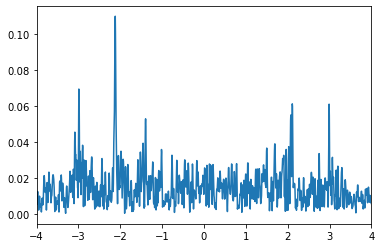

In [58]:
plt.plot(NCCF.delay, np.abs(signal.hilbert(NCCF_w)))
plt.xlim([-4, 4])

## Visualize Arrival Times

In [8]:
fn = '/datadrive/NCCFs/arrival_times/filtered.nc'
ds = xr.open_dataset(fn)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(17897.0, 18262.0)

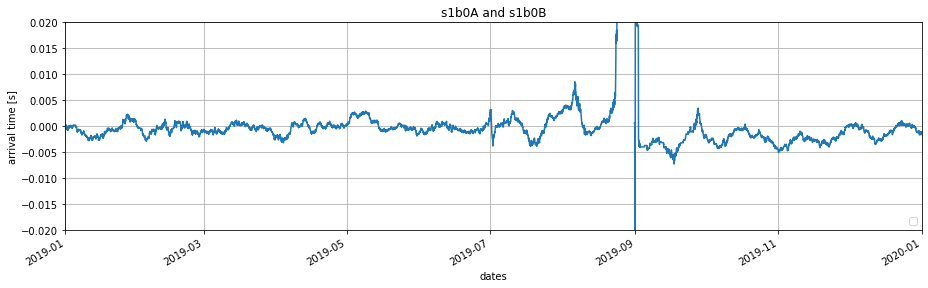

In [16]:
peak = 's1b0A'

fig = plt.figure(figsize=(13,4))
(-1*ds['s1b0A'] - ds['s1b0B']).plot()
plt.ylim([-0.02, 0.02])
plt.xlim([ds.dates[0], ds.dates[-1]])
plt.legend(loc='lower right')
plt.grid()
plt.title(peak + ' and s1b0B')
#plt.title(peak)
plt.ylabel('arrival time [s]')

plt.tight_layout()
#plt.savefig(f'figures/8year/{peak}_s1b0B_filtered_arrival_time.png', dpi=300)
plt.xlim([pd.Timestamp('2019-01-01'), pd.Timestamp('2020-01-01')])

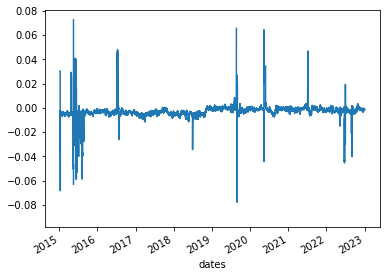

In [11]:
(-1*ds['s1b0A'] - ds['s1b0B']).plot()

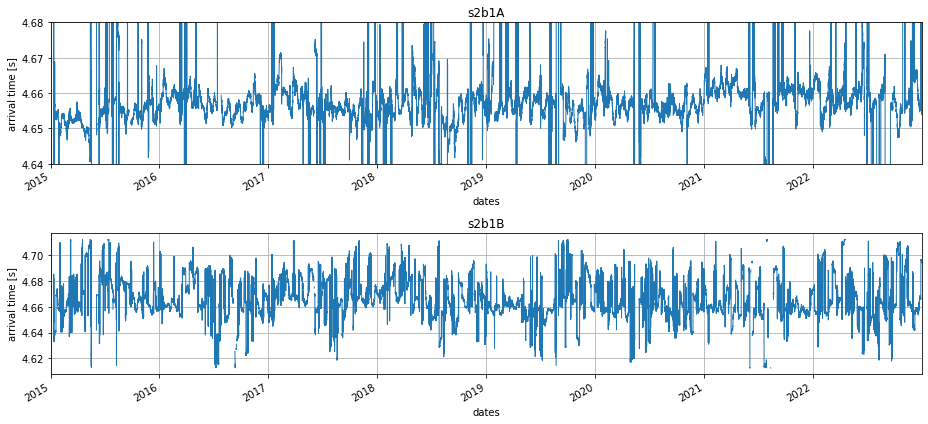

In [39]:
fig, axes = plt.subplots(2,1,figsize=(13,6))
axes = axes.flatten()

plt.sca(axes[0])
peak = 's2b1A'
(-1*ds[peak]).plot(linewidth=1, label='s2b1A', ax=axes[0])
plt.ylim([4.64, 4.68])
plt.xlim([ds.dates[0], ds.dates[-1]])
#plt.legend(loc='lower right')
plt.grid()
plt.title(peak)
plt.ylabel('arrival time [s]')

plt.sca(axes[1])
peak = 's2b1B'
ds[peak].plot(linewidth=1, label='s2b1A', ax=axes[1])
#plt.ylim([2.98, 3])
plt.xlim([ds.dates[0], ds.dates[-1]])
#plt.legend(loc='lower right')
plt.grid()
plt.title(peak)
plt.ylabel('arrival time [s]')

plt.tight_layout()
plt.savefig(f'figures/8year/s2b1_filtered_arrival_time.png', dpi=300)
#plt.xlim([pd.Timestamp('2019-01-01'), pd.Timestamp('2021-01-01')])